## Regression Analysis with Keras

Neural networks are not only able to perform classification task as previously introduced, but can also forecast continuous values. This type of prediction task is often called regression or regression analysis. In principle, the neural networks' architectures are constructed analogous to the previous examples, except for a few changes. First, the activation function for the output neuron needs to be changed. A value between zero and one, as the sigmoid function would output is meaningless. Therefore, it is changed to be the linear identity function $f(x)=x$. Second, an equally important, is the consideration of the loss function to be optimized. Instead of measuring a binary choice, the distance to the continuous variable needs to be expressed. There is a wide variety of possible loss functions. In practice, however, the mean-square-error (mse) $\overline{(y - \hat{y})^2}$ or the mean-absolute-deviation (mae) $|y - \hat{y}|$ is frequently used.


### Setup

For a detailed explanation of the used modules, please refer to the respective sections in the [introductory notebook](0_MNIST_dataset.ipynb) and [logistic regression notebook](1_logistic_regression.ipynb).

In [70]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import Sequence
from keras.regularizers import l2
from keras import optimizers

### Loading the Data

This time, we are going to work on a different dataset called 'abalone'. It stems from the field of biology and records physical properties of 4177 abalones ("sea snails"), like their height, width, weight etc. Again, the data is stored in an HDF5 file with two datasets, one containing the actual data, and another with the names of the measured properties.

In [83]:
def load_data(path='abalone.h5'):
    """
    Loads a dataset and its column names from the HDF5 file specified by the path.
    It is assumed that the HDF5 dataset containing the data is called 'data' and the columns are called 'columns'.

    Parameters
    ----------
    path : str, optional
        The absolute or relative path to the HDF5 file, defaults to mnist.h5.

    Returns
    -------
    data_and_labels : tuple(np.array[samples, features], np.array[features])
        a tuple with two numpy array containing the data and column names
    """
    with h5py.File(path, 'r') as handle:
        return np.array(handle['data']), list(column.decode('utf-8') for column in handle['columns'])
    
data, columns = load_data()
data.shape, columns

((4177, 9),
 ['Sex',
  'Length',
  'Diameter',
  'Height',
  'Whole weight',
  'Shucked weight',
  'Viscera weight',
  'Shell weight',
  'Rings'])

### The Data at a Glance

Let's have a very brief look at the data by plotting each of the nine features in a histogram. You will note, one curiosity about the actually categorical 'sex' column. The creators of the dataset have encoded three possible value, -1 for male, 1 for female and additionally 0 for infants. All the other observables do not expose any particularities.

The prediction task at hand is to forecast how old and abalone is-their ring count + 1,5 years. It is possible to determine the ring count using a combination of colorants and microscopic work. This is somewhat a time consuming and expensive procedure, we would like to replace by a solid prediction based on proxy value, i.e. physical properties of the abalone.

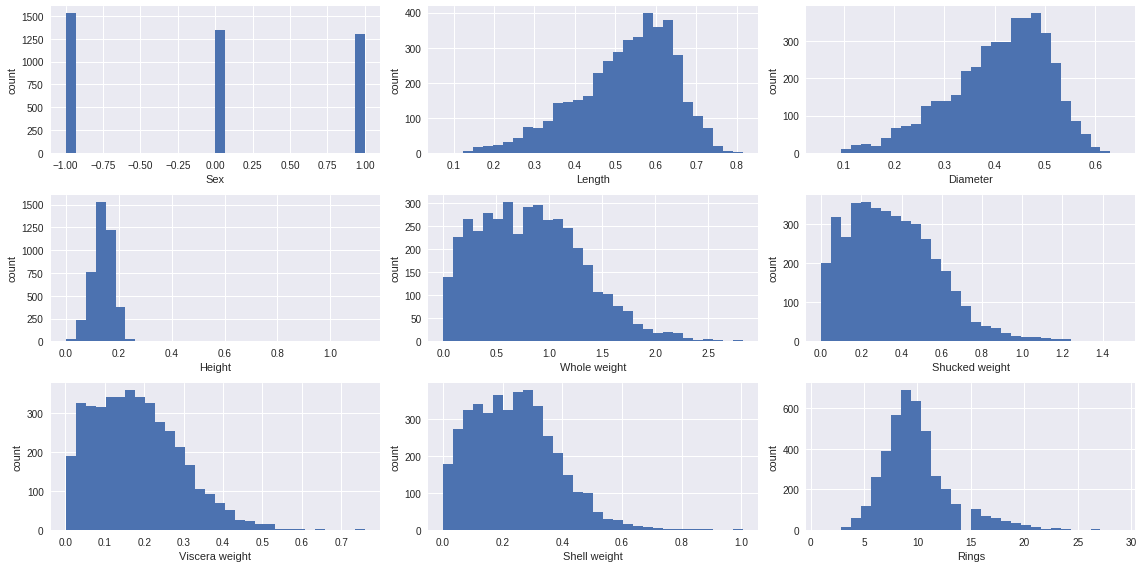

In [84]:
def plot_bins(data, columns):
    """
    Plots the histograms of each of the passed columns of the data set.

    Parameters
    ----------
    data : np.array([samples, features])
        The data to be plotted.
    path : list
        The corresponding column names
    """
    features = data.shape[1]
    figure, axis = plt.subplots(3, features // 3, figsize=(16, 8))
    axis = np.array(axis).flatten()
    
    for i, variable in enumerate(columns):
        axis[i].hist(data[:, i], bins=30)
        axis[i].set_xlabel(variable)
        axis[i].set_ylabel('count')
        
    plt.tight_layout()
    plt.show()
    
plot_bins(data, columns)

### Data Preprocessing

The abalone dataset is already in good shape when it comes to data cleaning, i.e. no missing values, removed noise, etc., but need to be further preprocessed before we are able to feed it to a neural network. While somewhat close, the value ranges of the input variables are spread differently. We need to bring to normalize these to a common value system. Here, the mean of each individual feature will be substracted and then scaled by its standard deviation. This way, all variable are expressed as multiple of their own variation. It is important to determine these values from the training data partition alone. Otherwise, information from the test data would leak into the training process. Additionally, we are going to split off the feature to be predicted (rings) and divide the data into training and test data.

In [96]:
def split_and_preprocess(data, train_fraction=3.0/4.0):    
    """
    Preprocesses that dataset by normalizing to mean-standard deviation and partitioning the data 
    into training and test data and corresponding labels.

    Parameters
    ----------
    data : np.array([samples, features])
        The data to be preprocessed and normalized
    train_fraction : float
        Fraction of samples to be assigned to the training dataset

    Returns
    -------
    train_data, train_labels, test_data, test_labels : 
    tuple(np.array[train samples, features], np.array[train samples],
          np.array[test samples, features], np.array[test samples]
    )
        a tuple with four numpy array containing the training and test data and labels
    """
    split_point = int(data.shape[0] * train_fraction)
    
    # split the data in train, test and corresponding labels
    label_index = -1
    train_labels, test_labels = data[:split_point, label_index], data[split_point:, label_index]
    train, test = data[:split_point, :label_index], data[split_point:, :label_index]
    
    # calculate the mean and standard deviation for each feature for normalization
    mean, sigma = train.mean(axis=0), train.std(axis=0)
    # do not normalize the categorical 'sex' column
    mean[0], sigma[0] = 0.0, 1.0
    
    return (train - mean) / sigma, train_labels, (test - mean) / sigma, test_labels
    
train_data, train_labels, test_data, test_labels = split_and_preprocess(data)

### Building an Appropriate Network

As described in the introduction, we will be using one of the previously neural network architectures-the fully-connected network. The most notable changes are the activation function of the output neuron, the MAE loss-function and a different optimizer called Nadam [1] for faster convergence. 

In [61]:
def build_model(data):
    """
    Constructs a fully-connected neural network model for the given dataset

    Parameters
    ----------
    data : np.array[samples, features]
        the image dataset

    Returns
    -------
    model : keras.Model
        the fully-connected neural network
    """
    model = Sequential()
    
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.1), input_shape=(data.shape[1],)))
    model.add(Dense(5, activation='tanh', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=optimizers.Nadam(lr=1e-4), loss='mae')
    
    return model

model = build_model(train_data)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                180       
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 105       
_________________________________________________________________
dropout_7 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


### Tracking the Training Progress

Tracking the training history of a Keras model using a callback is already familiar to you. Here, we have made a slight modification to only track the loss epoch-wise. In this case, the $\texttt{history}$ object returned by Keras' $\texttt{fit}$ call, would provide you with the same information.

In [62]:
class TrainingHistory(Callback):
    """
    Class for tracking the training progress/history of the neural network. Implements the keras.Callback interface.
    """
    def on_train_begin(self, logs):
        self.loss = []
        self.validation_loss = []
            
    def on_epoch_end(self, _, logs):
        """
        Callback invoked after each training batch.
        Should track the training loss and accuracy in the respective members.

        Parameters
        ----------
        _ : int
            unused, int corresponding to the batch number
        logs : dict{str -> float}
            a dictionary mapping from the observed quantity to the actual valu
        """
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])

### Training the Model

Training a regression model work exactly the same like a convolutional neural network in Keras.

In [97]:
def train_model(model, train_data, train_labels, test_data, test_labels, epochs=500, batch_size=32):
    """
    Trains a fully-connected neural network given training and test data/labels.

    Parameters
    ----------
    model : keras.Model
        the fully-connected neural network
    train_data : np.array[train samples, features]
        the training data
    train_labels : np.array[train samples]
        the labels, aka. the vector containing the ring count
    test_data : np.array[test samples, features]
        the test data
    test_labels : np.array[test samples]
        the labels, aka. the vector containing the ring count
    epoch: positive int, optional
        the number of epochs for which the neural network is trained, defaults to 100
    batch_size: positive int, optional
        the size of the training batches, defaults to 32

    Returns
    -------
    history : TrainingHistory
        the tracked training and test history
    """
    history = TrainingHistory()
    model.fit(
        train_data, train_labels, validation_data=(test_data, test_labels),
        epochs=epochs, shuffle=True, callbacks=[history]
    )
    
    return history
    
history = train_model(model, train_data, train_labels, test_data, test_labels)

Train on 3132 samples, validate on 1045 samples
Epoch 1/500
3132/3132 [==============================] - 0s 35us/step - loss: 2.1735 - val_loss: 1.7512
Epoch 2/500
3132/3132 [==============================] - 0s 31us/step - loss: 2.1523 - val_loss: 1.7514
Epoch 3/500
3132/3132 [==============================] - 0s 32us/step - loss: 2.1406 - val_loss: 1.7479
Epoch 4/500
3132/3132 [==============================] - 0s 32us/step - loss: 2.1495 - val_loss: 1.7487
Epoch 5/500
3132/3132 [==============================] - 0s 32us/step - loss: 2.1569 - val_loss: 1.7508
Epoch 6/500
3132/3132 [==============================] - 0s 34us/step - loss: 2.1709 - val_loss: 1.7510
Epoch 7/500
3132/3132 [==============================] - 0s 33us/step - loss: 2.1564 - val_loss: 1.7507
Epoch 8/500
3132/3132 [==============================] - 0s 34us/step - loss: 2.1120 - val_loss: 1.7518
Epoch 9/500
3132/3132 [==============================] - 0s 35us/step - loss: 2.1336 - val_loss: 1.7505
Epoch 10/500
313

3132/3132 [==============================] - 0s 39us/step - loss: 2.0803 - val_loss: 1.7355
Epoch 79/500
3132/3132 [==============================] - 0s 35us/step - loss: 2.1031 - val_loss: 1.7372
Epoch 80/500
3132/3132 [==============================] - 0s 34us/step - loss: 2.0516 - val_loss: 1.7390
Epoch 81/500
3132/3132 [==============================] - 0s 39us/step - loss: 2.0828 - val_loss: 1.7395
Epoch 82/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.0757 - val_loss: 1.7348
Epoch 83/500
3132/3132 [==============================] - 0s 35us/step - loss: 2.0684 - val_loss: 1.7358
Epoch 84/500
3132/3132 [==============================] - 0s 44us/step - loss: 2.0672 - val_loss: 1.7348
Epoch 85/500
3132/3132 [==============================] - 0s 44us/step - loss: 2.0811 - val_loss: 1.7365
Epoch 86/500
3132/3132 [==============================] - 0s 50us/step - loss: 2.0715 - val_loss: 1.7324
Epoch 87/500
3132/3132 [==============================] - 0s 41us/st

3132/3132 [==============================] - 0s 29us/step - loss: 2.0225 - val_loss: 1.7286
Epoch 156/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.0210 - val_loss: 1.7270
Epoch 157/500
3132/3132 [==============================] - 0s 29us/step - loss: 1.9976 - val_loss: 1.7251
Epoch 158/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.0273 - val_loss: 1.7302
Epoch 159/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.0277 - val_loss: 1.7239
Epoch 160/500
3132/3132 [==============================] - 0s 29us/step - loss: 2.0099 - val_loss: 1.7236
Epoch 161/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.0050 - val_loss: 1.7247
Epoch 162/500
3132/3132 [==============================] - 0s 32us/step - loss: 2.0116 - val_loss: 1.7269
Epoch 163/500
3132/3132 [==============================] - 0s 30us/step - loss: 2.0172 - val_loss: 1.7293
Epoch 164/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 38us/step - loss: 1.9772 - val_loss: 1.7210
Epoch 233/500
3132/3132 [==============================] - 0s 32us/step - loss: 1.9992 - val_loss: 1.7215
Epoch 234/500
3132/3132 [==============================] - 0s 31us/step - loss: 1.9479 - val_loss: 1.7210
Epoch 235/500
3132/3132 [==============================] - 0s 32us/step - loss: 1.9897 - val_loss: 1.7195
Epoch 236/500
3132/3132 [==============================] - 0s 32us/step - loss: 1.9758 - val_loss: 1.7164
Epoch 237/500
3132/3132 [==============================] - 0s 31us/step - loss: 1.9613 - val_loss: 1.7164
Epoch 238/500
3132/3132 [==============================] - 0s 31us/step - loss: 1.9425 - val_loss: 1.7155
Epoch 239/500
3132/3132 [==============================] - 0s 35us/step - loss: 1.9540 - val_loss: 1.7175
Epoch 240/500
3132/3132 [==============================] - 0s 34us/step - loss: 1.9663 - val_loss: 1.7169
Epoch 241/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 28us/step - loss: 1.9392 - val_loss: 1.7121
Epoch 310/500
3132/3132 [==============================] - 0s 26us/step - loss: 1.9291 - val_loss: 1.7116
Epoch 311/500
3132/3132 [==============================] - 0s 37us/step - loss: 1.9446 - val_loss: 1.7119
Epoch 312/500
3132/3132 [==============================] - 0s 28us/step - loss: 1.9101 - val_loss: 1.7141
Epoch 313/500
3132/3132 [==============================] - 0s 28us/step - loss: 1.9576 - val_loss: 1.7164
Epoch 314/500
3132/3132 [==============================] - 0s 29us/step - loss: 1.9366 - val_loss: 1.7107
Epoch 315/500
3132/3132 [==============================] - 0s 29us/step - loss: 1.9436 - val_loss: 1.7126
Epoch 316/500
3132/3132 [==============================] - 0s 31us/step - loss: 1.9548 - val_loss: 1.7133
Epoch 317/500
3132/3132 [==============================] - 0s 32us/step - loss: 1.9332 - val_loss: 1.7119
Epoch 318/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 31us/step - loss: 1.9058 - val_loss: 1.7091
Epoch 387/500
3132/3132 [==============================] - 0s 30us/step - loss: 1.8956 - val_loss: 1.7055
Epoch 388/500
3132/3132 [==============================] - 0s 34us/step - loss: 1.8920 - val_loss: 1.7084
Epoch 389/500
3132/3132 [==============================] - 0s 31us/step - loss: 1.9366 - val_loss: 1.7068
Epoch 390/500
3132/3132 [==============================] - 0s 30us/step - loss: 1.9190 - val_loss: 1.7079
Epoch 391/500
3132/3132 [==============================] - 0s 75us/step - loss: 1.9015 - val_loss: 1.7117
Epoch 392/500
3132/3132 [==============================] - 0s 37us/step - loss: 1.9057 - val_loss: 1.7071
Epoch 393/500
3132/3132 [==============================] - 0s 31us/step - loss: 1.9013 - val_loss: 1.7050
Epoch 394/500
3132/3132 [==============================] - 0s 32us/step - loss: 1.8665 - val_loss: 1.7048
Epoch 395/500
3132/3132 [==============================] - 0

3132/3132 [==============================] - 0s 31us/step - loss: 1.8988 - val_loss: 1.7055
Epoch 464/500
3132/3132 [==============================] - 0s 30us/step - loss: 1.8811 - val_loss: 1.7029
Epoch 465/500
3132/3132 [==============================] - 0s 29us/step - loss: 1.8703 - val_loss: 1.7013
Epoch 466/500
3132/3132 [==============================] - 0s 28us/step - loss: 1.8910 - val_loss: 1.7019
Epoch 467/500
3132/3132 [==============================] - 0s 29us/step - loss: 1.8955 - val_loss: 1.7027
Epoch 468/500
3132/3132 [==============================] - 0s 28us/step - loss: 1.8878 - val_loss: 1.7009
Epoch 469/500
3132/3132 [==============================] - 0s 38us/step - loss: 1.8792 - val_loss: 1.7024
Epoch 470/500
3132/3132 [==============================] - 0s 30us/step - loss: 1.8672 - val_loss: 1.7041
Epoch 471/500
3132/3132 [==============================] - 0s 28us/step - loss: 1.8800 - val_loss: 1.7010
Epoch 472/500
3132/3132 [==============================] - 0

### Visualization of the Training Progress

Using matplotlib, we are plotting the model's loss during the training phase. It should result in an almost textbook-like smooth decay.

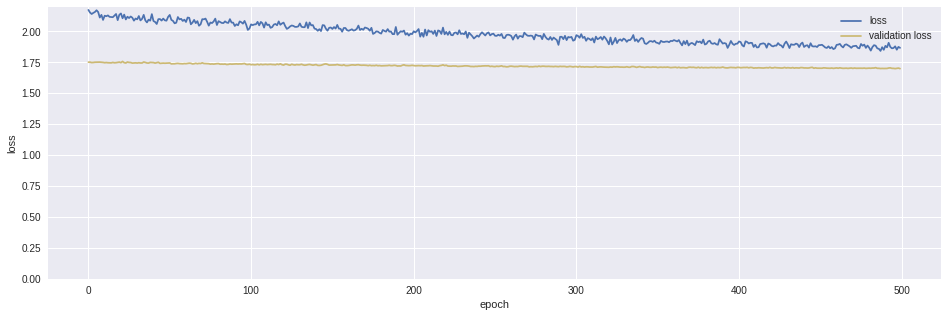

In [98]:
def plot_history(history):
    """
    Plots the training (batch-wise) and test (epoch-wise) loss and accuracy.

    Parameters
    ----------
    history : TrainingHistory
        an instance of TrainingHistory monitoring callback
    """
    figure, axis = plt.subplots(1, 1, figsize=(16, 5))
    
    # plot the training loss and accuracy
    axis.set_xlabel('epoch')
    axis.set_ylabel('loss')
    
    epochs = np.arange(len(history.loss))
    axis.plot(epochs, history.loss, color='C0', label='loss')
    axis.plot(epochs, history.validation_loss, color='C4', label='validation loss')
    axis.set_ylim(bottom=0.0)
    
    # display a legend
    axis.legend(loc=1)
    plt.show()

plot_history(history)

### Very Brief Evaluation of the Model

Using Keras' evaluate function we can one again obtain the loss of the model on the test data. You should be seeing an MAE of roughly 1.75, meaning that on average we mispredict the number of rings by that number. So is this prediction useful? That is highly dependent on the particular application domain of the predictor. However, we may see whether the network is better than the mere fluctuation within the data.

Note: a further optimization of the network will result in an MAE of roughly 1.0.

In [95]:
print('MAE of the prediction:', model.evaluate(test_data, test_labels))
print('Standard deviation of the labels:', test_labels.std())

1045/1045 [==============================] - 0s 23us/step
MAE of the prediction: 1.7527956922088515
Standard deviation of the labels: 3.0637561840139056


### References

[1] **Incorporating Nesterov Momentum into Adam**, *Dozat, Timothy*, (2016).